# Using an Artificial Neural Network for the Task of Road Following

## Introduction

Autonomous driving is getting increased attention nowadays. While it was a pure research
topic in the 1980s, today there are many companies which develop self-driving cars. The algorithms
used by autonomous driving systems can vary widely from traditional vision and robotic techniques to
artificial neural networks. Since autonomous driving is a problem with a lot of noise and variability
in the input data it is hard to optimize traditional techniques to perform well. That is why
researchers developed artificial neural networks for the task of road following in the 1980s.
This work is based on the paper "ALVINN: An Autonomous Land Vehicle in a Neural Network" by
Pomerleau et al. and explores how a neural network can be used for the task of road following.
The neural network gets an image of a street as input and outputs a steering wheel angle. This is called
an end-to-end steering system which should not be confused with semantic segmentation or object
detection frequently used by autonomous driving systems nowadays.

## The Idea

This section introduces the neural network that was used by Pomerleau et al. in the paper ALVINN for the task of road following. 

![ALVINN Idea](graphic/ALVINN_Idea.png)

The network is a 3-layer back-propagation network that uses the data of a camera and laser range finder as an input and outputs the steering angle in which the vehicle should drive. This can be seen in the graphic above. The camera input has a dimension of 30x32 pixels and only the blue color cannel is used. The blue cannel is choosen because it provides the best contrast between the road and the neighbouring environment. The laser range finder input has a dimension of 8x32 pixels where each pixel indicates the proximity of objects in front of the car. This information can be used by the neural network to avoid obstacles on the road. Additionally the network has a road intensity feedback unit which outputs whether the road is lighter than the surrounding environment or not. This output is fed with the next input into the neural network. The input data is flattend into a vector and then fed to the input layer. The exact dimensions and the structure described here can be seen in the following graphic.

![Neural Network](graphic/AVLINN_Network.png)

The output of the neural network are 45 units that describe the steering wheel angel plus one unit for the road insensity feedback. Since the output is no continues value the steering angles have to be encoded in an appropriated manner. This is done by assigning each angle to the corresponding output unit. The unit in the middle means thereby driving straight ahead and the units to the left and the right mean steering to the left or to the right. The values for the output units are zero except for a "hill" where the angel is assigned to. The exact values are 0.10, 0.32, 0.61, 0.89, 1.00, 0.89, 0.61, 0.32, 0.10 and are centered around angle's output unit. A graphical representation can be seen in the data preprocessing section below.

### Data Set

Training a neural network requires massiv amount of labeled training samples. Since collecting such a data set is time consuming, the authors of the ALVINN paper used simulated road images to train their neural network. They generated 1200 samples with various camera orientations, lighting conditions and noise levels.

### Training

The training of the neural network is executed through back-propagation using the 1200 simulated road images. The optimization consists of two phases. In the first phase, the road intensity unit is given random values as input. The goal hereby is that the road intensity output unit does not just copy the input value but deduce it from the acutal image. In the second phase after the network learned this relationship the road intensity input unit is given real brightness values from the previous image.

The authors of the ALVINN paper stated that after 40 epochs of training the network was able to predict the correct steering angle within two units in about 90% of newly created simulated road images. Furthermore the authors tested the neural network in the NAVLAB vehicle which is a modified Chevy van with multiple computers, a camera and a laser range finder. The neural network was able to steer the vehicle at a speed of 1/2 meter per second on a 400 meter path over the CMU campus. The results where comparable to the best traditional vision-based road following algorithm at CMU but this algorithm needed months of manual parameter tuning. Whereas the neural network was able to learn this in half an hour once the data set was created.

## Implementation

This work implements a version of the ALVINN neural network using Tensorflow and real road images from an openly available data set. Since there was no laser range finder data and no label for the road intensity unit, this implementation is only based on camera images. This is no problem for showing the general idea of the ALVINN paper. The authors concluded anyway that the laser range finder is not important as long as the vehicle is not driving off-road. Another difference is that the data set used in this work has images of the size 60x64 and not 30x32. Later on there is a comparision how the network performs with the higher resultion compared to the lower one from the paper.

In the following the data set is loaded, preprocessed and split into train and test data. Afterwards the neural network is trained and evaluated on the test data.

In [1]:
# imports and configurations
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np
np.random.seed(1)

project_path = "/opt/project/"

import sys
sys.path.insert(0, project_path)

## Loading the Data Set

The following code loads a data set that contains the images and the corresponding steering wheel angles from a simple test track.

In [2]:
# load data set
import h5py

X = []
y = []
with h5py.File(f"{project_path}data/track_data_2.h5", "r") as f:
    for image, label in zip(f['images'], f['angles']):
        X.append(image)
        y.append(label)

X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.float32)

print(f"Data set size: {len(X)}")
print(f"Image size: {X[0].shape}")

Data set size: 2000
Image size: (60, 64)


In [3]:
# visualize the data set
from visualization import visualize_angle_in_gif, visualize_angle_in_mp4

visualize_angle_in_gif(X, y, fn="training_data_visualization")
visualize_angle_in_mp4(X, y, fn="training_data_visualization")

Video size: (320, 300)


The following GIF shows the steering angle for each image displayed as
a green line.

![Training data visualization](graphic/training_data_visualization.gif)

Images minimal pixel value: 7.0
Images maximal pixel value: 255.0

Minimal steering angle: -165.42462158203125
Maximal steering angle: 23.003211975097656


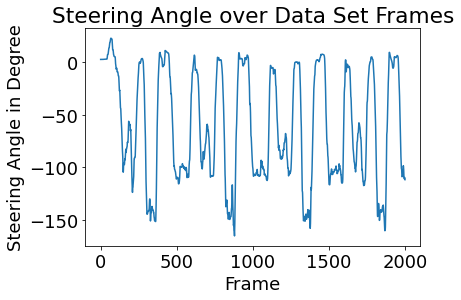

In [4]:
# exploring the data set
print(f"Images minimal pixel value: {X.min()}")
print(f"Images maximal pixel value: {X.max()}")
print()
print(f"Minimal steering angle: {y.min()}")
print(f"Maximal steering angle: {y.max()}")

plt.plot(y)
plt.title("Steering Angle over Data Set Frames")
plt.ylabel("Steering Angle in Degree")
plt.xlabel("Frame");

## Data Set Preprocessing

Before the neural network can be trained, the input data has to be normalized.
This is done by using Min-Max normalization with a minimum of 0.0 and a maximum
of 255.0.

Furthermore, each steering wheel angle has to be assigned to one of 45 bins.
This is not simply done by one-hot encoding the assigned bin but by encoding
the angle with the following values 0.1, 0.32, 0.61, 0.89, 1.0, 0.89, 0.61, 0.32, 0.1.
The target bin is the one with the 1.0 value and the ones left and right
get the other values.

Training data size: 1400


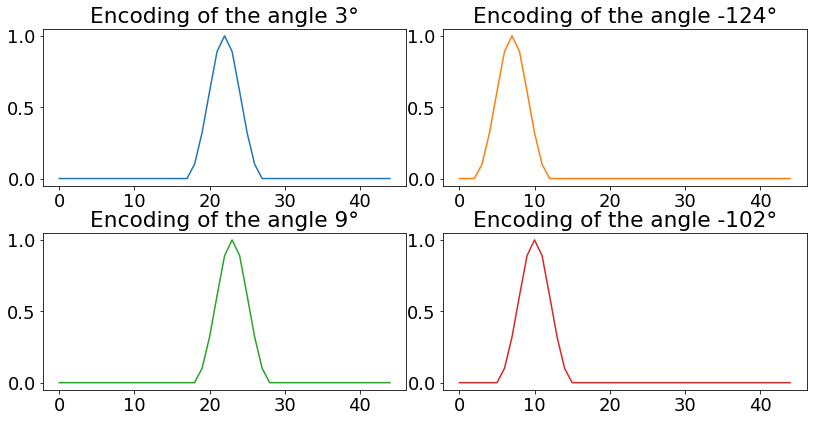

In [5]:
# data preprocessing
from sklearn.utils import shuffle

import utils

# normalize the images
X_normalized = X / 255.0

# encode the angles
y_encoded = utils.encode_angle(y, output_bins=45)

# visualize encoding
fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.3, wspace=.1)
axs[0, 0].plot(y_encoded[0])
axs[0, 0].set_title(f"Encoding of the angle {round(y[0])}°")
axs[0, 1].plot(y_encoded[300], 'tab:orange')
axs[0, 1].set_title(f"Encoding of the angle {round(y[300])}°")
axs[1, 0].plot(y_encoded[50], 'tab:green')
axs[1, 0].set_title(f"Encoding of the angle {round(y[50])}°")
axs[1, 1].plot(y_encoded[1000], 'tab:red')
axs[1, 1].set_title(f"Encoding of the angle {round(y[1000])}°")

# split data into train (70%) and test data (30%)
train_data_size = round(len(X) * 0.7)
print(f"Training data size: {train_data_size}")

X_train = X_normalized[:train_data_size]
y_train = y_encoded[:train_data_size]

# shuffle data before training
X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_test = X_normalized[train_data_size:]
y_test = y_encoded[train_data_size:]


## Training

This section defines a version of the ALVINN neural network and trains the network on the test track data set. The accuracy is computed as defined in the ALVINN paper: If the predicted result deviates from the optimal result in at most one unit, it is seen as correctly classified.

In [6]:
# ALVINN accuracy function
def alvinn_accuracy(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()
    acc = 0.0
    for y0, y1 in zip(y_true, y_pred):
        y0_argmax = np.argmax(y0)
        y1_argmax = np.argmax(y1)
        if abs(y0_argmax - y1_argmax) < 2:
            acc += 1.0
    return acc / float(len(y_true))

In [7]:
# initialize tensorflow
%env TF_CPP_MIN_LOG_LEVEL=3
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
print(f"Tensorflow version {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")
tf.random.set_seed(1)
tf.config.run_functions_eagerly(True)

# model definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(60, 64)),
    tf.keras.layers.Dense(29, activation=tf.keras.activations.sigmoid),
    tf.keras.layers.Dense(45, activation=None)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[alvinn_accuracy]
              )

env: TF_CPP_MIN_LOG_LEVEL=3
Tensorflow version 2.5.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# train the neural network
history = model.fit(X_train, y_train, epochs=100)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
44/44 [==============================] - 1s 8ms/step - loss: 0.0987 - alvinn_accuracy: 0.0878
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0676 - alvinn_accuracy: 0.1847
Epoch 3/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0644 - alvinn_accuracy: 0.3525
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0612 - alvinn_accuracy: 0.4309
Epoch 5/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0582 - alvinn_accuracy: 0.4730
Epoch 6/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0553 - alvinn_accuracy: 0.4872
Epoch 7/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0525 - alvinn_accuracy: 0.4915
Epoch 8/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0500 - alvinn_accuracy: 0.4988
Epoch 9/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0477 - alvinn_accuracy: 0.5012
Epoch 10/100
44/44 [==========================

44/44 [==============================] - 0s 7ms/step - loss: 0.0079 - alvinn_accuracy: 0.9292
Epoch 78/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0078 - alvinn_accuracy: 0.9335
Epoch 79/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0077 - alvinn_accuracy: 0.9306
Epoch 80/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0076 - alvinn_accuracy: 0.9366
Epoch 81/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0075 - alvinn_accuracy: 0.9363
Epoch 82/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0073 - alvinn_accuracy: 0.9354
Epoch 83/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0073 - alvinn_accuracy: 0.9444
Epoch 84/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0072 - alvinn_accuracy: 0.9392
Epoch 85/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0071 - alvinn_accuracy: 0.9403
Epoch 86/100
44/44 [==============================

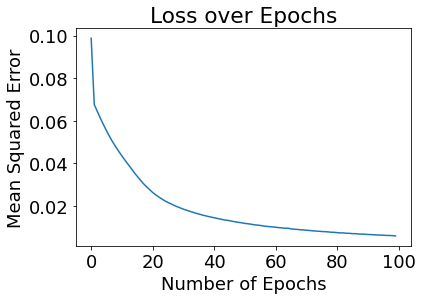

In [9]:
plt.plot(history.history["loss"])
plt.title("Loss over Epochs")
plt.ylabel("Mean Squared Error")
plt.xlabel("Number of Epochs");

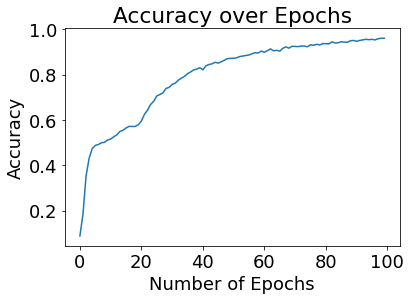

In [10]:
    plt.plot(history.history["alvinn_accuracy"])
    plt.title("Accuracy over Epochs")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of Epochs");

## Evaluation

19/19 [==============================] - 0s 6ms/step - loss: 0.0105 - alvinn_accuracy: 0.8816


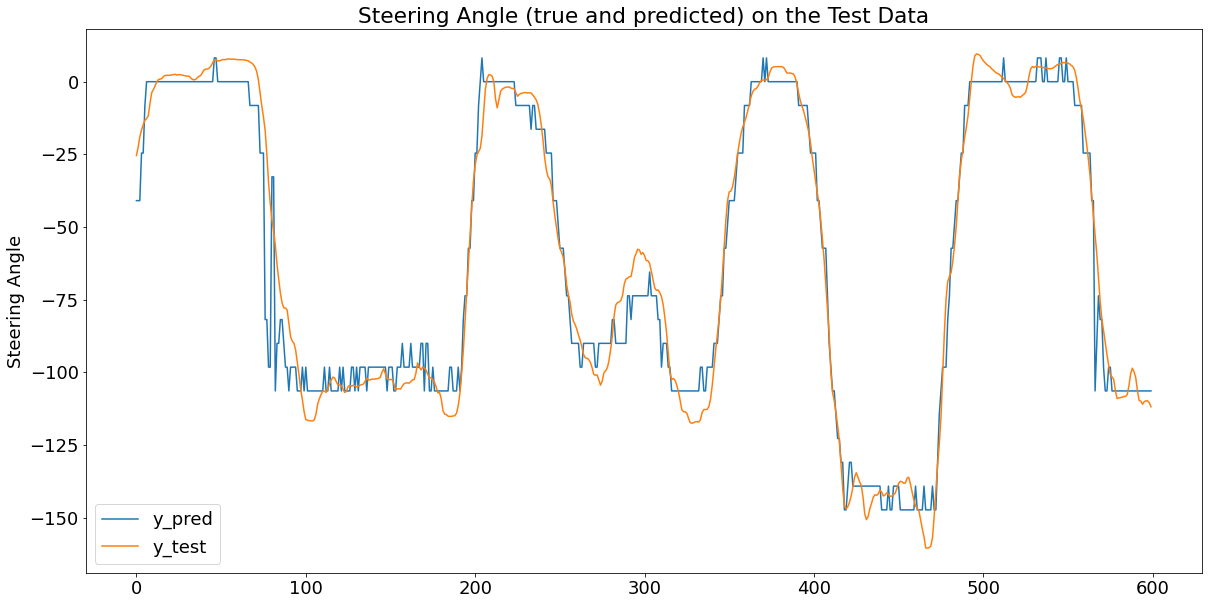

In [11]:
# testing and visualization
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

y_pred_degree = utils.decode_angle(y_pred, output_bins=45)
y_test_degree = y[train_data_size:]

plt.figure(figsize=(20,10))
plt.plot(y_pred_degree, label="y_pred")
plt.plot(y_test_degree, label="y_test")
plt.legend()
plt.title("Steering Angle (true and predicted) on the Test Data")
plt.ylabel("Steering Angle");

In [12]:
# visualize the performance in a video
visualize_angle_in_gif(X[train_data_size:], y_test_degree, y_pred_degree, "test_data_visualization")
visualize_angle_in_mp4(X[train_data_size:], y_test_degree, y_pred_degree, fn="test_data_visualization")

Video size: (320, 300)


![test data visualization](graphic/test_data_visualization.gif)

As can be seen in the video above the algorithm is able to successfully steer the car on the test track.

## Network Representation
This section analyses on two example hidden units what the network has learned.

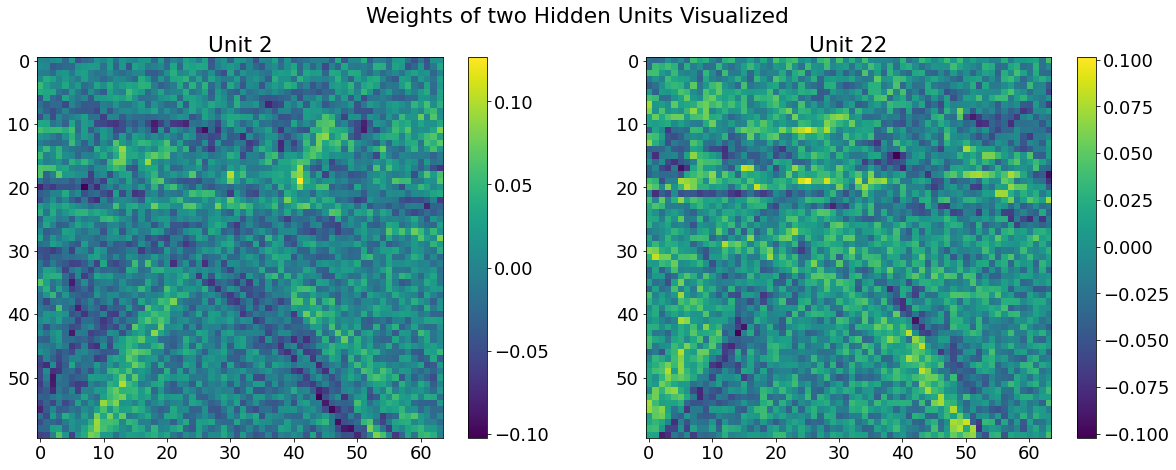

In [13]:
weights = model.layers[1].get_weights()[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Weights of two Hidden Units Visualized")

im = ax1.imshow(weights.T[2].reshape(60, 64))
ax1.set_title("Unit 2")
fig.colorbar(im, ax=ax1)

im = ax2.imshow(weights.T[22].reshape(60, 64))
ax2.set_title("Unit 22")
fig.colorbar(im, ax=ax2);

The images above show the weights from two hidden units. As it can be seen in the images the hidden units filter for the road marking. 

The unit in the left image filters for two straight lines because there the weights have high values. Additional, the weights for a left-skewed road marking are very low. Consequently, this unit is filtering for straight road marking.

The unit in the right image filters for left-skewed lines because there the weights have high values --FINISH--

## Exploring Different Parameters

This section analyises the effects that the input size and the number of output units have on the prediction performance. To prevent code repetition the following cell contains two functions. One function is to train the ALVINN network with variable parameteres and the second one is to evaluate the trained model.

In [14]:
from data_set import DataSet, CommaAiDataSet, ReferenceDataSet

class TrainingRun:
    def __init__(self, ds: DataSet, input_size=None, output_bins=45, epochs=100):
        self.ds = ds
        self.input_size = input_size
        self.output_bins = output_bins
        self.epochs = epochs

        
def train(tr: TrainingRun): 
    tf.random.set_seed(1)
    np.random.seed(1)
    
    # load data and preprocess them
    tr.ds.preprocessing(scale=tr.input_size, output_bins=tr.output_bins)
    x_train, y_train = tr.ds.get_train_data()

    input_shape = x_train[0].shape

    # define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(29, activation=tf.keras.activations.sigmoid),
        tf.keras.layers.Dense(tr.output_bins, activation=None)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[alvinn_accuracy]
                  )

    # train the model
    print("---- Training ----")
    history = model.fit(x_train, y_train, epochs=tr.epochs)
    
    return model, history

def evaluate(model, tr: TrainingRun):
    print("---- Training Metrics ----")
    plt.plot(history.history["loss"])
    plt.title("Loss over Epochs")
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Number of Epochs")
    plt.show()

    plt.plot(history.history["alvinn_accuracy"])
    plt.title("Accuracy over Epochs")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of Epochs")
    plt.show()
    
    
    print("---- Testing ----")
    x_test, y_test = tr.ds.get_test_data()
    model.evaluate(x_test, y_test)
    y_pred = model.predict(x_test)

    # visualize the prediction angle
    y_pred_degree = utils.decode_angle(y_pred, output_bins=tr.output_bins)
    y_test_degree = utils.decode_angle(y_test, output_bins=tr.output_bins)

    r = len(x_test)
    x = range(r)
    plt.figure(figsize=(20,10))
    plt.plot(x, y_pred_degree, label="y_pred")
    plt.plot(x, y_test_degree, label="y_test")
    plt.legend()
    plt.title("Steering Angle (true and predicted) on the Test Data")
    plt.ylabel("Steering Angle")

    # visualize true and predicted angle in the images
    visualize_angle_in_gif(tr.ds.X_resized[tr.ds.train_data_length:], y_test_degree, y_pred_degree,
                           fn=f"visualization_{tr.ds.__class__.__name__}_{tr.epochs}_{tr.input_size}_{tr.output_bins}".replace(" ", ""))
    visualize_angle_in_mp4(tr.ds.X_resized[tr.ds.train_data_length:], y_test_degree, y_pred_degree,
                           fn=f"visualization_{tr.ds.__class__.__name__}_{tr.epochs}_{tr.input_size}_{tr.output_bins}".replace(" ", ""))

### Using the Original Input Size

In the ALVINN paper the input images have the size 30x32. The next cell analyzes what effect the smaller images have on the algorithm performance.

In [15]:
tr = TrainingRun(ds=ReferenceDataSet(), input_size=(32, 30), output_bins=45, epochs=100)
model, history = train(tr=tr)

---- Training ----
Epoch 1/100
22/44 [==============>...............] - ETA: 0s - loss: 0.2001 - alvinn_accuracy: 0.0000e+00

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


44/44 [==============================] - 0s 8ms/step - loss: 0.1608 - alvinn_accuracy: 0.0121
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0820 - alvinn_accuracy: 0.0705
Epoch 3/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0695 - alvinn_accuracy: 0.2519
Epoch 4/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0650 - alvinn_accuracy: 0.3438
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0618 - alvinn_accuracy: 0.3816
Epoch 6/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0592 - alvinn_accuracy: 0.3875
Epoch 7/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0569 - alvinn_accuracy: 0.4233
Epoch 8/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0549 - alvinn_accuracy: 0.4276
Epoch 9/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0531 - alvinn_accuracy: 0.4363
Epoch 10/100
44/44 [==============================] - 0s 7

44/44 [==============================] - 0s 8ms/step - loss: 0.0146 - alvinn_accuracy: 0.8158
Epoch 78/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0145 - alvinn_accuracy: 0.8182
Epoch 79/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0143 - alvinn_accuracy: 0.8224
Epoch 80/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0142 - alvinn_accuracy: 0.8210
Epoch 81/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0141 - alvinn_accuracy: 0.8284
Epoch 82/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0139 - alvinn_accuracy: 0.8303
Epoch 83/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0138 - alvinn_accuracy: 0.8253
Epoch 84/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0137 - alvinn_accuracy: 0.8293
Epoch 85/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0136 - alvinn_accuracy: 0.8336
Epoch 86/100
44/44 [==============================

---- Training Metrics ----


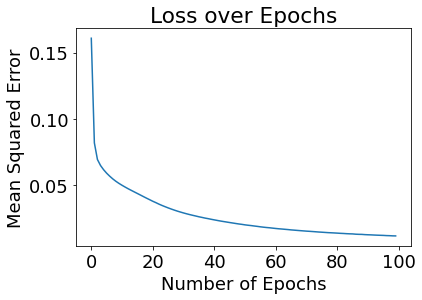

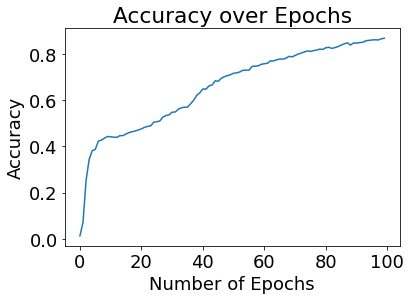

---- Testing ----
19/19 [==============================] - 0s 5ms/step - loss: 0.0154 - alvinn_accuracy: 0.7670
Video size: (320, 300)


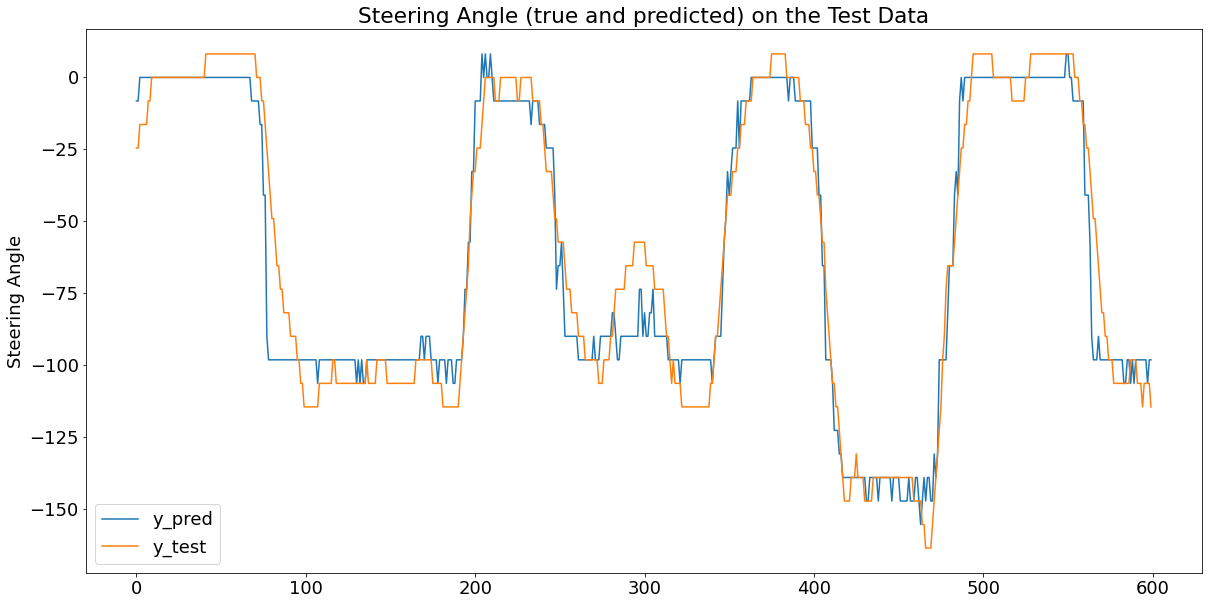

In [16]:
evaluate(model=model, tr=tr)

![Test with smaller input size](graphic/visualization_ReferenceDataSet_100_(32,30)_45.gif)

In the previous graphics, it can be seen that downsampling the images does have some impact on the prediction performance. The accuracy was decreased by roughly 10%. This is probably due to the fact that the number of features was reduced dramatically.

### Increasing the Number of Output Units

In [17]:
tr = TrainingRun(ds = ReferenceDataSet(), input_size=(64,60), output_bins=65, epochs=100)
model, history = train(tr=tr)

---- Training ----
Epoch 1/100
16/44 [=========>....................] - ETA: 0s - loss: 0.1251 - alvinn_accuracy: 0.1914

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


44/44 [==============================] - 0s 7ms/step - loss: 0.0803 - alvinn_accuracy: 0.1875
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0495 - alvinn_accuracy: 0.2166
Epoch 3/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0481 - alvinn_accuracy: 0.2024
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0469 - alvinn_accuracy: 0.1996
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0458 - alvinn_accuracy: 0.2249
Epoch 6/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0448 - alvinn_accuracy: 0.2652
Epoch 7/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0438 - alvinn_accuracy: 0.2831
Epoch 8/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0428 - alvinn_accuracy: 0.2997
Epoch 9/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0419 - alvinn_accuracy: 0.3149
Epoch 10/100
44/44 [==============================] - 0s 7

44/44 [==============================] - 0s 8ms/step - loss: 0.0103 - alvinn_accuracy: 0.8359
Epoch 78/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0101 - alvinn_accuracy: 0.8464
Epoch 79/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0100 - alvinn_accuracy: 0.8388
Epoch 80/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0099 - alvinn_accuracy: 0.8530
Epoch 81/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0098 - alvinn_accuracy: 0.8482
Epoch 82/100
44/44 [==============================] - 0s 7ms/step - loss: 0.0096 - alvinn_accuracy: 0.8565
Epoch 83/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0095 - alvinn_accuracy: 0.8544
Epoch 84/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0094 - alvinn_accuracy: 0.8506
Epoch 85/100
44/44 [==============================] - 0s 8ms/step - loss: 0.0093 - alvinn_accuracy: 0.8563
Epoch 86/100
44/44 [==============================

---- Training Metrics ----


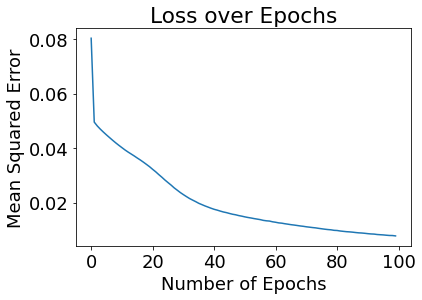

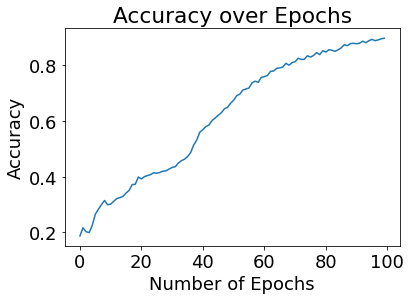

---- Testing ----
19/19 [==============================] - 0s 5ms/step - loss: 0.0116 - alvinn_accuracy: 0.7681
Video size: (320, 300)


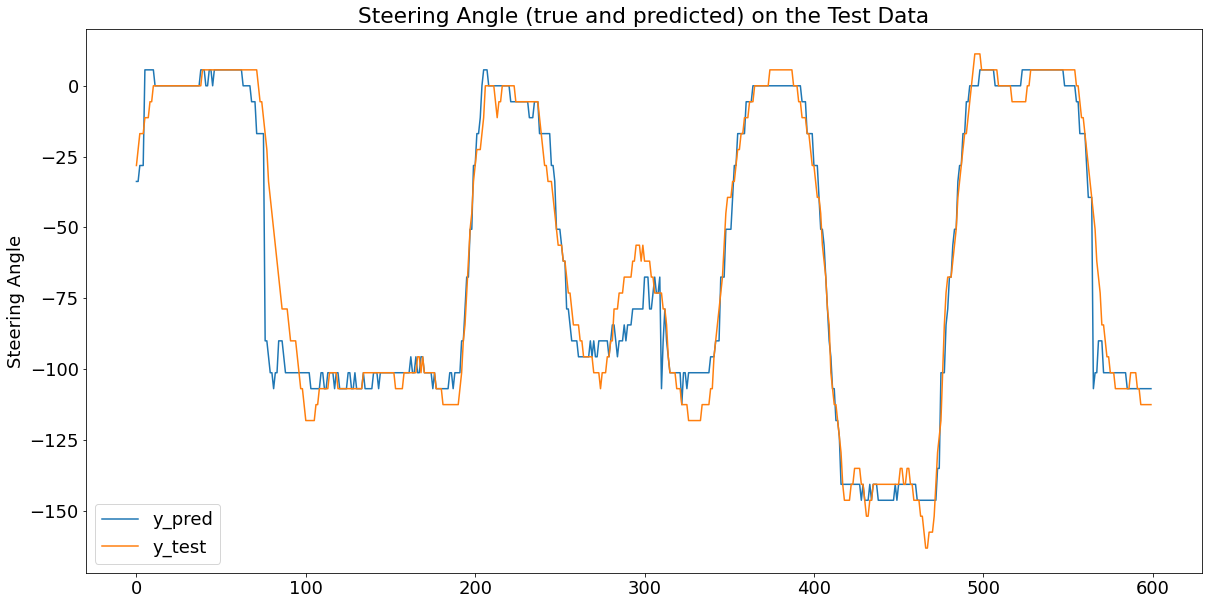

In [18]:
evaluate(model=model, tr=tr)

![Test with more output bins](graphic/visualization_ReferenceDataSet_100_(64,60)_65.gif)

In the graphics above it can be seen, that increasing the number of output units significantly worsens the prediction performance. This happens probably because there are more possible angles that can be predicted.

## Training on a Real World Data Set

So fare the algorithm was only trained on a simple test track with a clear road marking. This section trains and tests the performance of the ALVINN neural network on real world data. This data set was created by [comma.ai](https://research.comma.ai/) and contains mostly driving on a highway.

In [19]:
ds = CommaAiDataSet()
ds.normalize_steering_angle()
visualize_angle_in_gif(ds.X, ds.y, fn="commaai_data_set")
visualize_angle_in_mp4(ds.X, ds.y, fn="commaai_data_set")

(18177, 3, 160, 320)
X shape: (12200, 3, 160, 320)
y shape: (12200,)
Video size: (320, 300)


Visualization of the comma.ai data set in full resolution. The network will be trained with images resized to 60x64.

![Comma Ai Data Set](graphic/commaai_data_set.gif)

In [20]:
tr = TrainingRun(ds=CommaAiDataSet(), input_size=(64,60), output_bins=45, epochs=30)
model, history = train(tr=tr)

(18177, 3, 160, 320)
X shape: (12200, 3, 160, 320)
y shape: (12200,)
---- Training ----
Epoch 1/30
 15/229 [>.............................] - ETA: 1s - loss: 0.1280 - alvinn_accuracy: 0.4708   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


229/229 [==============================] - 2s 7ms/step - loss: 0.0420 - alvinn_accuracy: 0.8687
Epoch 2/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0116 - alvinn_accuracy: 0.9424
Epoch 3/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0076 - alvinn_accuracy: 0.9446
Epoch 4/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0073 - alvinn_accuracy: 0.9464
Epoch 5/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0071 - alvinn_accuracy: 0.9489
Epoch 6/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0070 - alvinn_accuracy: 0.9524
Epoch 7/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0068 - alvinn_accuracy: 0.9549
Epoch 8/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0067 - alvinn_accuracy: 0.9572
Epoch 9/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0066 - alvinn_accuracy: 0.9601
Epoch 10/30
229/229 [===========================

---- Training Metrics ----


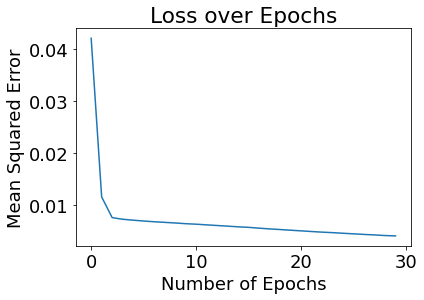

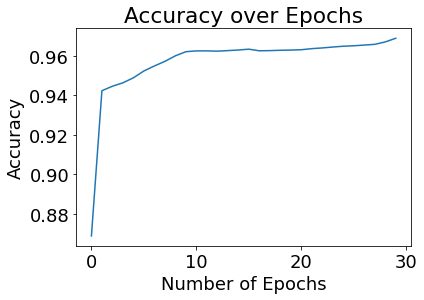

---- Testing ----
153/153 [==============================] - 1s 5ms/step - loss: 0.0135 - alvinn_accuracy: 0.9048
Video size: (320, 300)


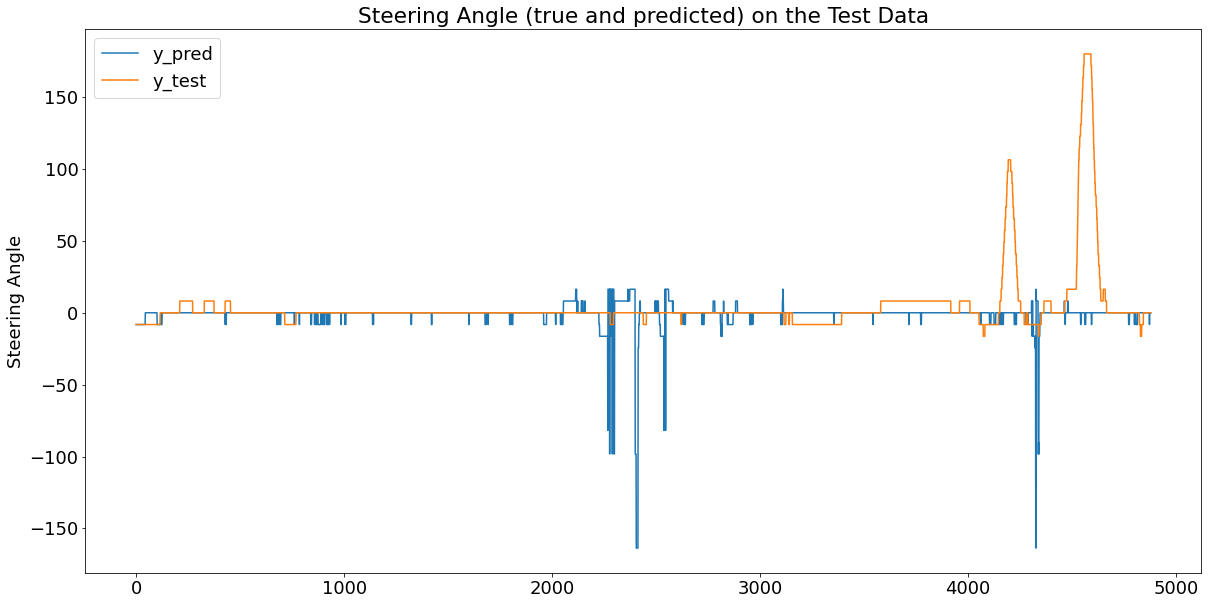

In [21]:
evaluate(model=model, tr=tr)

![Test on the Comma Ai data set](graphic/visualization_CommaAiDataSet_30_(64,60)_45.gif)

The accuracy of the ALVINN network on the real world data is quite good but this is probably due to the fact that the steering wheel angle on a highway does not move that much to the left or the right. So predicting an angle in the direction straight ahead gives mostly a good result. 

As can be seen in the video above the algorithm can follow the road if the road marking is clearly visible in front of the car. This is a similar situation to the test track analysed previously in this work. If the road marking is not clearly visible, the algorithm has difficulties to predict the correct angle. This happens for example if a car is changing lanes directly in front of the car. The algorithm wants to avoid the car and steer to the opposite direction but this is not good because there are other cars. Furthermore the algorithm cannot deal with the car itself changing lanes but this is expected since the algorithm is not supposed to do this. Another interesting thing to see is the ending of the test data where the car leaves the highway and turns into a housing area. Since the network has not seen such data during the training in cannot predict a correct angle anymore. This is probably one of the biggest drawback of this approach to autonomous driving.

### Using a Lower Resolution on the Real World Data Set

In this section the ALVINN network is once again trained on the real world data set but the input and output dimensions are aligned with those from the paper.

In [22]:
tr = TrainingRun(ds=CommaAiDataSet(), input_size=(32,30), output_bins=45, epochs=30)
model, history = train(tr=tr)

(18177, 3, 160, 320)
X shape: (12200, 3, 160, 320)
y shape: (12200,)
---- Training ----
Epoch 1/30
 22/229 [=>............................] - ETA: 1s - loss: 0.1606 - alvinn_accuracy: 0.3551  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


229/229 [==============================] - 2s 7ms/step - loss: 0.0569 - alvinn_accuracy: 0.8757
Epoch 2/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0136 - alvinn_accuracy: 0.9407
Epoch 3/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0083 - alvinn_accuracy: 0.9438
Epoch 4/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0079 - alvinn_accuracy: 0.9439
Epoch 5/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0078 - alvinn_accuracy: 0.9440
Epoch 6/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0077 - alvinn_accuracy: 0.9443
Epoch 7/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0076 - alvinn_accuracy: 0.9444
Epoch 8/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0075 - alvinn_accuracy: 0.9443
Epoch 9/30
229/229 [==============================] - 2s 7ms/step - loss: 0.0074 - alvinn_accuracy: 0.9442
Epoch 10/30
229/229 [===========================

---- Training Metrics ----


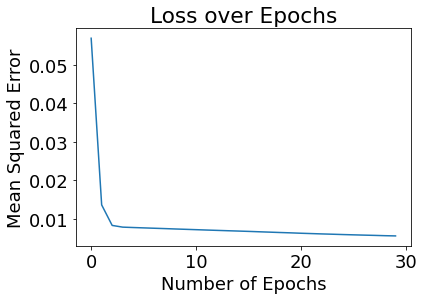

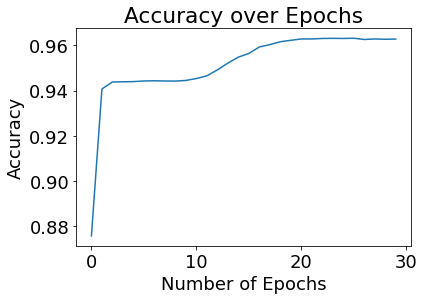

---- Testing ----
153/153 [==============================] - 1s 5ms/step - loss: 0.0110 - alvinn_accuracy: 0.9289
Video size: (320, 300)


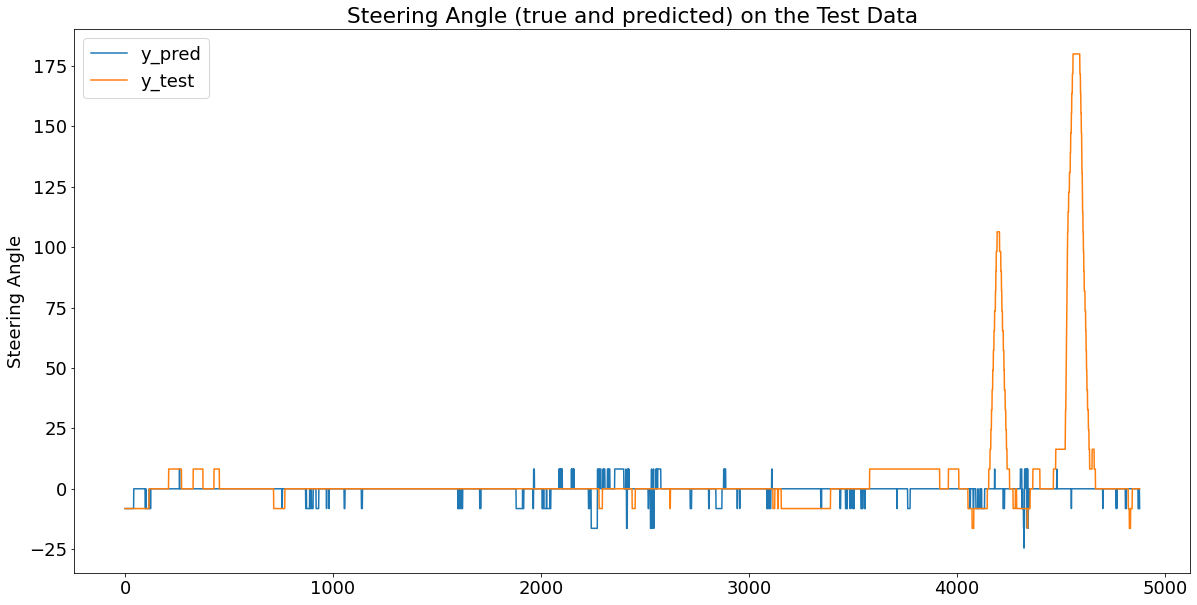

In [23]:
evaluate(model=model, tr=tr)

![Low resolution on comma ai data set](graphic/visualization_CommaAiDataSet_30_(32,30)_45.gif)

ACCURACY IS BETTER?

## Discussion

This work showed that it is possible to sucessfully steer a car using a neural network. The main advantages of this approach are that it is less susceptible to noise and that the development is easy and fast once an appropriated data set is collected. Furthermore it is easy to assimilate different sensors, for example, camera and laser range finder as it is done in the ALVINN network.

One of the biggest drawback of this approach is that the neural network will only be able to drive in similar conditions as it was trained in. This is visible at the end of the real world data set test where the car drives into the housing area. Since the network is trained only with images from the highway it cannot predict an accurate steering wheel angle in this situation. Additionally the data set should not only contain examples of perfect driving but should also contain examples of how to return to the road center if the driver makes a mistake.
Another problem arises on crossroads and road forks because there are multiple possible travel directions. This can result in an oscillation between two very different directions.

## Summary

Neural network based end-to-end steering systems are a powerful tool for autonomous driving if they are trained with a sufficient amount of real world data. While this approach to autonomous driving is currently probably to unpredictable for cities it could be quite interessting for road following on highways or in remote areas. With more sophisticated models it could maybe be possible in the future to also navigate in more complex situations with neural networks. NVIDIA, for example, trained a convolutional neural network (CNN) to sucessfully steer a car in a width variety of situations. They used a data set with 72 hours of driving on different road types and under different weather conditions to optimize the network. Another example with a similar approach is the company comma.ai. They already sell hardware to equip existing vehicles with self driving car hardware making the cars able to navigate autonomously on highways.

## Sources

- Pomerleau, Dean A (1989). Alvinn: An autonomous land vehicle in a neural network
- Test track data set: https://github.com/stephencwelch/self_driving_cars
- Real world data set: https://research.comma.ai/
- Mariusz, Davide, Daniel, Bernhard, et al. (2016). End to End Learning for Self-Driving Cars